![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Text Mining: Models and Algorithms

## Pre-Processing

This session will be about pre-processing text. This is a very important part of text analysis and we will spend some time doing things by "hand" that we later use packages for. We will do this to understand why we are pre-processing in a particular way and how pre-processing can be used to explore the corpus.

We will start with six easy steps:
- remove punctuation (and other stuff you don't want)
- unify - for example, make everything lowercase
- tokenization
- vector representation of documents and the document-term matrix
- introduction to n-grams
- some thoughts on trimming the vocabulary

It is absolutely crucial that you understand what each of these steps are and how they work. You need to understand every detail of this notebook. We will start building on what we are doing today. Often, the steps we dicuss today will disappear in packages that we are using but there is no(!) chance you will understand the later methods without understanding today's lecture.

Credits for some pieces of code go to Jason Brownlee (https://machinelearningmastery.com/clean-text-machine-learning-python/) and Allison Parrish (https://github.com/aparrish/rwet/blob/master/ngrams-and-markov-chains.ipynb). Both inspired some twists and turns in this notebook.

In [9]:
### PREAMBLE

from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

### LOAD TEXT
path=r"/Users/mathiasschindler/Dropbox/-BSE_TextM/Data_collection"
sep = "/"

my_file = Path(path + sep + "UN_corpus_clean.csv")

corpus_data = pd.read_csv(my_file, delimiter=',', encoding='utf-8')

corpus_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19551 entries, 0 to 19550
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   resolution  19551 non-null  int64 
 1   year        19551 non-null  int64 
 2   paragraph   19551 non-null  int64 
 3   demand      19551 non-null  int64 
 4   match       19551 non-null  int64 
 5   text        19551 non-null  object
 6   title       10908 non-null  object
 7   date        6311 non-null   object
dtypes: int64(5), object(3)
memory usage: 1.2+ MB


### Exercise 1

1) Write a loop that tokenizes and cleans the first 1000 paragraphs in the UN corpus. We will call this our corpus for now.

2) Generate vector representations of the 1000 paragraphs. All vectors together are called the document term matrix. What are the dimensions of this matrix?

3) Provide an analysis of the top terms in the corpus. How meaningful do you find them for distinguishing paragraphs?

In [10]:
def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word): #{2,} is repetitions, e.g. \d{4,} is 4 digits in a row
        return word
    else:
        return word.lower()

def vectorize(tokens):
    vector = []
    for w in vocab:
        vector.append(tokens.count(w))
    return vector

In [11]:
# 1) TOKENIZE AND CLEAN 

# Empty list to be filled with vectorized text data
corpus = []

for n in range(1000):
    
    # Save a row in a temp variable
    paragraph = corpus_data['text'][n]
    
    # Split the string into list where each word is a list element
    single_words = paragraph.split()
    
    # For each word in list 'words': 
    #   1) Apply strip() which removes all non characters and digits and keeps possesive nouns together
    #   2) Apply abbr_or_lower() which makes lower case except if it is an abbreviation (as MINUSMA)
    cleaned_words = [abbr_or_lower(strip(w)) for w in single_words]
    
    # Save vocabulary for each row in corpus
    # - These only contain the each unique words in its first occurence in the string
    vocab, index = {}, 1  # start indexing from 1
    
    for token in cleaned_words:
      if token not in vocab:
        vocab[token] = index
        index += 1
    
    # Invese vocab (for columns in df)
    vocab_inv = {index: token for token, index in vocab.items()}
    
    # Vectorize
    vectorized = vectorize(cleaned_words)
    
    # Save vector as df with single row and:
    #   1) Rename columns to text expressed using inverted dictionary 'vocab'
    #   2) Name each df numbered
    globals()["corpus_" + str(n)] = pd.DataFrame([vectorized])
    globals()["corpus_" + str(n)] = globals()["corpus_" + str(n)].rename(vocab_inv, axis = 1)

In [12]:
# clear previous 'corpus' iterations
#corpus = []

In [13]:
# 2) GENERATE VECTOR / MATRIX REPRESENTATION
for n in range(999):
    corpus_n = globals()["corpus_" + str(n)]
    corpus_n1 = globals()["corpus_" + str(n+1)]
    
    if n == 0:
        corpus = pd.concat([corpus_n, corpus_n1], axis = 0, ignore_index = True)
        
    else:
        corpus = pd.concat([corpus, corpus_n1], axis = 0, ignore_index = True)
        
# Fill missing values with zero and format to int instead of float or missing
for k in corpus.columns:
    corpus[k] = corpus[k].fillna(0)
    
# Format datatypes in df to int to save memory
corpus = corpus.astype(int)

# Add column sums
corpus.loc['Total']= corpus.sum()

# Sort columns according to total
corpus = corpus.sort_values(by ='Total', axis=1, ascending = False)

# Print resulting dataframe
corpus.tail()

# Print resulting dataframe
corpus

,of,and,the,to,in,that,0,requests,with,government,...,HighLevel,finalize,1910,2073,transparently,safeguard,broadly,IGADs,fighting,fighters
0,2,1,1,1,1,0,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,1,0,0,6,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2,2,2,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1,1,1,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,2,1,1,1,1,2,1,0,4,0,...,0,0,0,0,0,0,0,0,0,0
999,1,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
# duplicate columns?
corpus.columns.duplicated().any()

False

`pd.concat()` allows to have duplicate rows now, but not columns. Since we here only have duplicate rows it is not a problem. See also [this post on Stack Overflow](https://stackoverflow.com/questions/61514861/pandas-pd-concat-results-in-duplicated-columns).

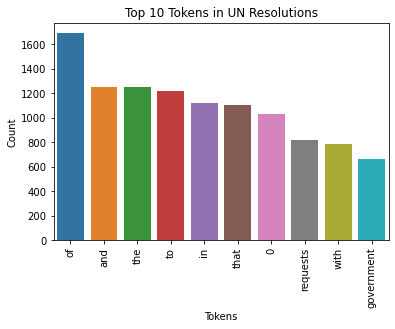

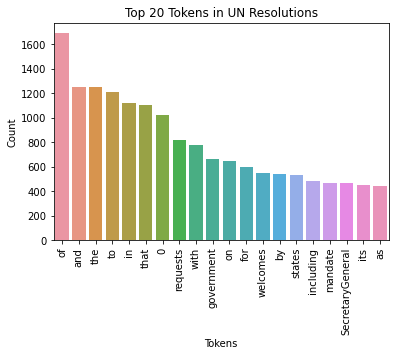

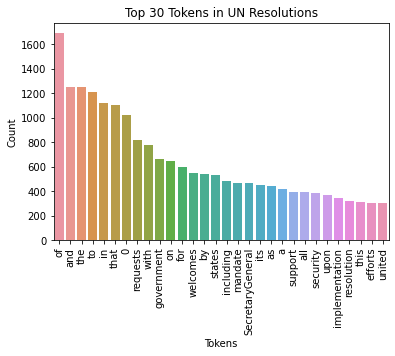

In [19]:
# Ignore error messages
import warnings
warnings.filterwarnings('ignore')

# Visualize top terms in corpus
top_n = [10, 20, 30]

# Make df with only sums of tokens for easier handling
corpus_top = corpus.loc['Total'].sort_values(ascending = False)

# Make barplots with seaborn for 
for n in top_n:
    df = corpus_top[:n]

    ax = sns.barplot(df, 
                x = df.index, 
                y = df.values,
               order = df.sort_values(ascending = False),
               orient = 'v')
    ax.set_title('Top ' + str(n) + ' Tokens in UN Resolutions')
    ax.set_ylabel('Count')
    ax.set_xlabel('Tokens')
    ax.set_xticklabels(df.index, rotation = 'vertical')

    plt.show()